In [2]:
# Ce notebook nécessite l'installation de geopandas pour les cartographies: uv pip install geopandas

In [3]:
import duckdb
from pipelines.tasks.config.common import DUCKDB_FILE
import pandas as pd
import os
import numpy as np

con = duckdb.connect(database=DUCKDB_FILE, read_only=True)

query = """
SELECT edc_prelevements.dateprel, edc_prelevements.heureprel,edc_prelevements.inseecommuneprinc, edc_prelevements.nomcommuneprinc, edc_prelevements.cdreseau, edc_prelevements.cdreseauamont, edc_resultats.*
FROM edc_prelevements
JOIN edc_resultats
ON edc_prelevements.referenceprel = edc_resultats.referenceprel
WHERE
(dateprel >= '2020-01-01')
AND
(cdparametre IN (1244,1246,1243,1245,1239,1242,1241,1885,1626,1240,1627,1886,1628,3164,1625,2048,1624,7431,1091,1089,2032,1090,5437,5434,5432,5433,5435,5436,1884,2943,5803,5301,1032))
AND
(cdreseauamont is NULL)
"""

res = con.sql(query)
res = res.df()


Choses à faire :

Isoler les prélèvements de ces familles grâce à la catégorisation de Pauline (“Métaux Lourds”, “Sous produits de désinfection”, “PCB”, “Phtalates”, “HAP”)

Répondre aux questions

Combien de fois les paramètres ont été recherchés par an dans la France entière

Est-ce qu’il y a eu des recherches dans toutes les régions? Sinon, dans quelles régions ils ont été recherchés? (pas besoin de descendre à la commune à ce stade).

Pour chaque paramètre, quelle est la fréquence de quantification? (nombre de fois que le paramètre a été quantifié / nombre de fois que le paramètre est recherché dans l’année sur la France entière) (quantification = ’une concentration dans l’eau a pu être mesurée. Je ne sais pas comment cela se traduit dans les tableaux de résultats)

Lesquels sont associés dans la base de données à une limite de qualité et quelle est la valeur de la limite de qualité indiquée? (je vérifierai si ça concorde bien avec les arrêtés)

Pour ceux avec une limite de qualité, quelle est la fréquence de dépassement de cette limite par an? (nombre de fois qu’il y a un dépassement / nombre de fois que le paramètre est recherché dans l’année sur la France entière)

Résumer cela dans un tableau outline avec ça comme colonnes:

Nom du paramètre

Nombre de recherche par an France Entière

Dans quelles régions est-il recherché?

Fréquence de quantification

Fréquence de dépassement de la limite de qualité (si existante)

Valeur de la limite de qualité


# Historique des analyses par an et par paramètre


In [4]:
res["libminparametre"].unique()

array(['PCB 101', 'PCB 105', 'PCB 114', 'PCB 118', 'PCB 123', 'PCB 125',
       'PCB 126', 'PCB 128', 'PCB 138', 'PCB 149', 'PCB 153', 'PCB 156',
       'PCB 157', 'PCB 167', 'PCB 169', 'PCB 170', 'PCB 18', 'PCB 180',
       'PCB 189', 'PCB 194', 'PCB 20', 'PCB 209', 'PCB 28', 'PCB 31',
       'PCB 35', 'PCB 44', 'PCB 52', 'PCB 54', 'PCB 66', 'PCB 77',
       'PCB 81', 'Polychlorobiphéniles indicateurs',
       'Polychlorobiphéniles(PCB)'], dtype=object)

In [5]:
res[["cdparametre", "libminparametre", "limitequal"]].drop_duplicates()

,cdparametre,libminparametre,limitequal
0,1242,PCB 101,None
1,1627,PCB 105,None
2,5433,PCB 114,None
3,1243,PCB 118,None
4,5434,PCB 123,None
5,2943,PCB 125,None
6,1089,PCB 126,None
7,1884,PCB 128,None
8,1244,PCB 138,None
9,1885,PCB 149,None


On va compter combien de prélèvements ont été faits par paramètre et par année depuis 2020


In [6]:
query_countglobal = """SELECT cdparametre, ANY_VALUE(libminparametre) AS libminparametre, COUNT(referenceprel) AS Count, year(dateprel) AS Annee
FROM res
GROUP BY cdparametre, Annee
ORDER BY cdparametre,Annee"""

countglobal = con.sql(query_countglobal)
countglobal = countglobal.df()

In [7]:
countglobal.head(20)

,cdparametre,libminparametre,Count,Annee
0,1032,Polychlorobiphéniles(PCB),27,2020
1,1089,PCB 126,853,2020
2,1089,PCB 126,1061,2021
3,1089,PCB 126,933,2022
4,1089,PCB 126,514,2023
5,1089,PCB 126,400,2024
6,1090,PCB 169,853,2020
7,1090,PCB 169,1061,2021
8,1090,PCB 169,933,2022
9,1090,PCB 169,514,2023


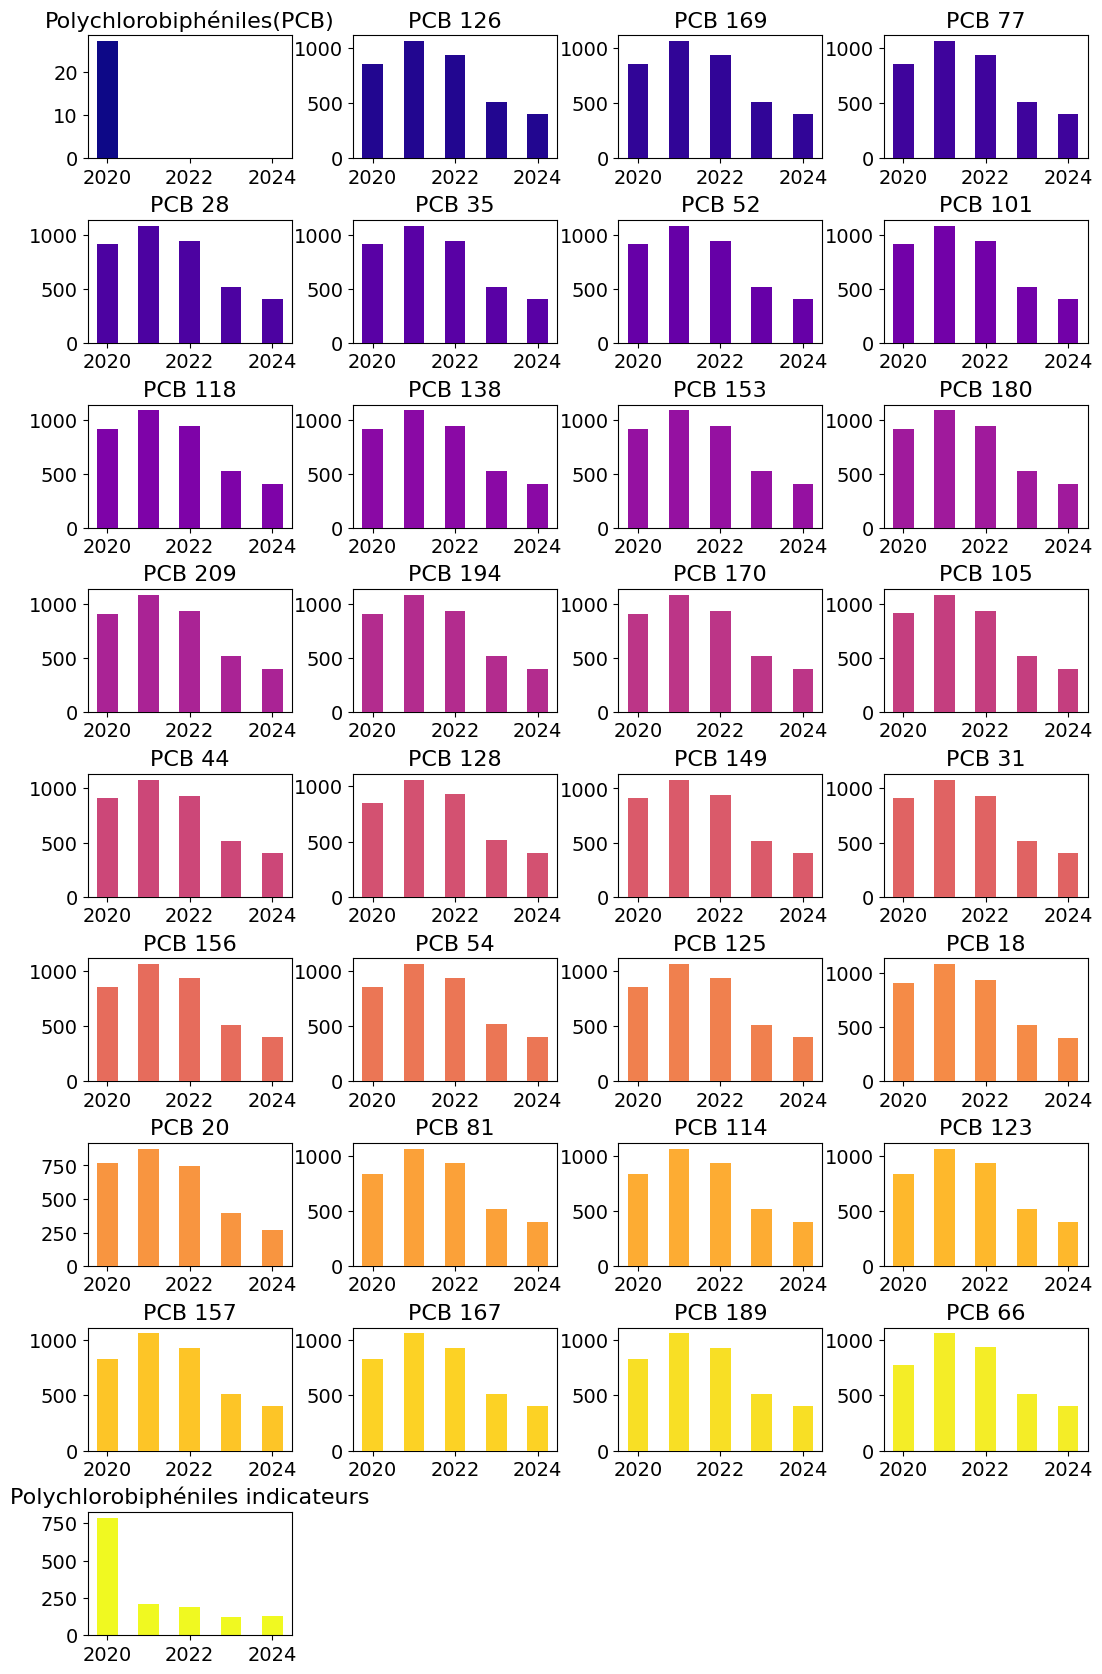

In [16]:
import matplotlib.pyplot as plt
import matplotlib

barWidth = 0.5

y = [2020, 2021, 2022, 2023, 2024]
y_data = []
aux = []
y_libminparametre = countglobal["libminparametre"].unique()
y_cdparametre = countglobal["cdparametre"].unique()
nb_param = len(y_cdparametre)

# On liste par annee le count de chaque parametre

for k in y_cdparametre:
    for m in y:
        arraux = countglobal[
            (countglobal["Annee"] == m) & (countglobal["cdparametre"] == k)
        ]["Count"]
        if len(arraux) > 0:
            aux.append(arraux.iloc[0])
        else:
            aux.append(0)
    y_data.append(aux)
    aux = []

br = [np.arange(len(y_data[0]))]

# for k in range(nb_param):
#    br.append([x + barWidth for x in br[k]])

f = plt.figure(figsize=(10, 16))
color = matplotlib.colormaps["plasma"]

for k in range(nb_param):
    plt.subplot(9, 4, k + 1)
    plt.bar(
        y,
        y_data[k],
        color=color(k / (nb_param - 1)),
        width=barWidth,
        zorder=nb_param - k,
        alpha=1.0,
    )
    plt.title(y_libminparametre[k], fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)


plt.subplots_adjust(wspace=0.3, hspace=0.5, left=0, right=1, bottom=0, top=1)
plt.show()

# Historique des recherches par région pour l'ensemble des métaux lourds


In [17]:
import geopandas as gpd

In [18]:
region = gpd.read_file(r"C:\Users\Admin\Downloads\regions-version-simplifiee.geojson")

In [19]:
geo = pd.read_csv(r"C:\Users\Admin\Downloads\20230823-communes-departement-region.csv")
geo_clean = geo.dropna(subset=["code_region"])
geo_clean["code_region"] = geo_clean["code_region"].astype(int)

C:\Users\Admin\AppData\Local\Temp\ipykernel_13364\1260320313.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_clean["code_region"] = geo_clean["code_region"].astype(int)


In [20]:
geo_clean.head()

,code_commune_INSEE,nom_commune_postal,code_postal,libelle_acheminement,ligne_5,latitude,longitude,code_commune,article,nom_commune,nom_commune_complet,code_departement,nom_departement,code_region,nom_region
0,1001,L ABERGEMENT CLEMENCIAT,1400,L ABERGEMENT CLEMENCIAT,NaN,46.153426,4.926114,1.0,L',Abergement-Clémenciat,L'Abergement-Clémenciat,1,Ain,84,Auvergne-Rhône-Alpes
1,1002,L ABERGEMENT DE VAREY,1640,L ABERGEMENT DE VAREY,NaN,46.009188,5.428017,2.0,L',Abergement-de-Varey,L'Abergement-de-Varey,1,Ain,84,Auvergne-Rhône-Alpes
2,1004,AMBERIEU EN BUGEY,1500,AMBERIEU EN BUGEY,NaN,45.960848,5.372926,4.0,NaN,Ambérieu-en-Bugey,Ambérieu-en-Bugey,1,Ain,84,Auvergne-Rhône-Alpes
3,1005,AMBERIEUX EN DOMBES,1330,AMBERIEUX EN DOMBES,NaN,45.996180,4.912273,5.0,NaN,Ambérieux-en-Dombes,Ambérieux-en-Dombes,1,Ain,84,Auvergne-Rhône-Alpes
4,1006,AMBLEON,1300,AMBLEON,NaN,45.749499,5.594320,6.0,NaN,Ambléon,Ambléon,1,Ain,84,Auvergne-Rhône-Alpes


In [21]:
query_region = """SELECT COUNT(referenceprel) AS Count, year(dateprel) AS Annee, ANY_VALUE(geo_clean.code_region) AS code_region, ANY_VALUE(geo_clean.nom_region) AS nom_region
FROM res
JOIN geo_clean
ON res.inseecommuneprinc=geo_clean.code_commune_INSEE
GROUP BY Annee,code_region
ORDER BY code_region,Annee"""

res_region = con.sql(query_region)
res_region = res_region.df()

In [22]:
res_region.head(15)

,Count,Annee,code_region,nom_region
0,21,2020,1,Guadeloupe
1,28,2021,1,Guadeloupe
2,28,2022,1,Guadeloupe
3,14,2024,1,Guadeloupe
4,45,2020,11,Île-de-France
5,6,2021,11,Île-de-France
6,18,2022,11,Île-de-France
7,6,2023,11,Île-de-France
8,27961,2020,27,Bourgogne-Franche-Comté
9,35489,2021,27,Bourgogne-Franche-Comté


In [23]:
# Plot cartographie par année

In [24]:
region["code"] = region["code"].astype(int)

In [ ]:
res_region_carto = region.join(res_region.set_index("code_region"), on="code")

In [202]:
res_region_carto = res_region_carto.set_geometry("geometry")

In [203]:
res_region_carto

,code,nom,geometry,Count,Annee,nom_region
0,11,Île-de-France,"POLYGON ((2.59052 49.07965, 2.63327 49.10838, ...",45.0,2020.0,Île-de-France
0,11,Île-de-France,"POLYGON ((2.59052 49.07965, 2.63327 49.10838, ...",6.0,2021.0,Île-de-France
0,11,Île-de-France,"POLYGON ((2.59052 49.07965, 2.63327 49.10838, ...",18.0,2022.0,Île-de-France
0,11,Île-de-France,"POLYGON ((2.59052 49.07965, 2.63327 49.10838, ...",6.0,2023.0,Île-de-France
1,24,Centre-Val de Loire,"POLYGON ((2.87463 47.52042, 2.88845 47.50943, ...",NaN,NaN,NaN
2,27,Bourgogne-Franche-Comté,"POLYGON ((3.62942 46.74946, 3.57569 46.74952, ...",27961.0,2020.0,Bourgogne-Franche-Comté
2,27,Bourgogne-Franche-Comté,"POLYGON ((3.62942 46.74946, 3.57569 46.74952, ...",35489.0,2021.0,Bourgogne-Franche-Comté
2,27,Bourgogne-Franche-Comté,"POLYGON ((3.62942 46.74946, 3.57569 46.74952, ...",30814.0,2022.0,Bourgogne-Franche-Comté
2,27,Bourgogne-Franche-Comté,"POLYGON ((3.62942 46.74946, 3.57569 46.74952, ...",16926.0,2023.0,Bourgogne-Franche-Comté
2,27,Bourgogne-Franche-Comté,"POLYGON ((3.62942 46.74946, 3.57569 46.74952, ...",13981.0,2024.0,Bourgogne-Franche-Comté


In [206]:
codes_na = res_region_carto["code"].unique()
annee_tempo = []
for l in range(len(codes_na)):
    df_tempo = res_region_carto[["code", "nom", "geometry"]]
    df_tempo = df_tempo[df_tempo["code"] == codes_na[l]]
    df_base = df_tempo[df_tempo["code"] == codes_na[l]]
    for k in range(len(y)):
        if (
            y[k]
            not in res_region_carto[res_region_carto["code"] == codes_na[l]][
                "Annee"
            ].to_numpy()
        ):
            annee_tempo.append(y[k])
    lat = len(annee_tempo)

    for m in range(lat - 1):
        df_tempo = pd.concat([df_tempo, df_base], ignore_index=True)
    df_tempo = df_tempo.reset_index()
    df_tempo = df_tempo.assign(Count=np.full(lat, 0.0))
    df_tempo = df_tempo.assign(Annee=np.full(lat, annee_tempo))
    df_tempo = df_tempo.reset_index()
    res_region_carto = pd.concat([res_region_carto, df_tempo], ignore_index=True)

    annee_tempo = []

ValueError: Length of values (1) does not match length of index (4)

In [ ]:
res_region_carto = res_region_carto[["code", "nom", "geometry", "Count", "Annee"]]

# Cartographie du nombre de prélèvements par année et par région pour l'ensemble de la catégorie métaux lourds


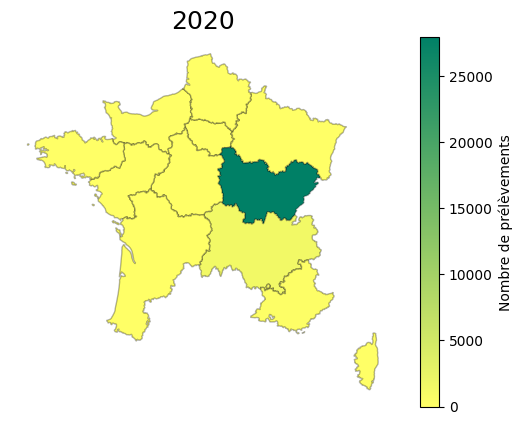

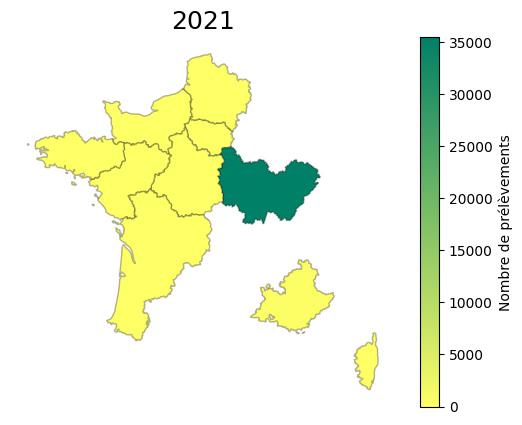

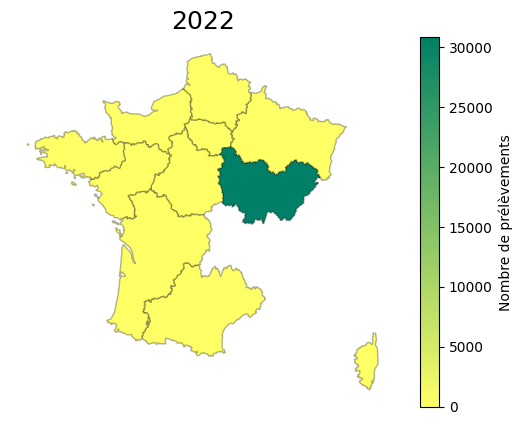

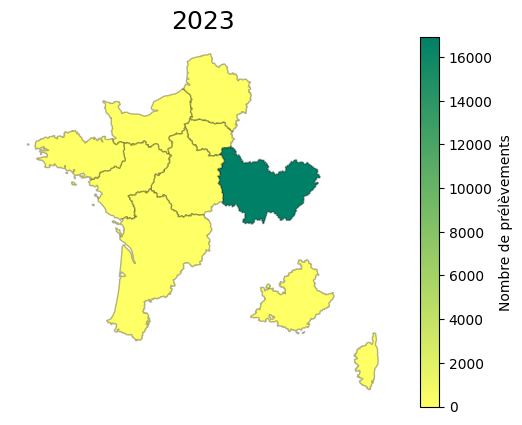

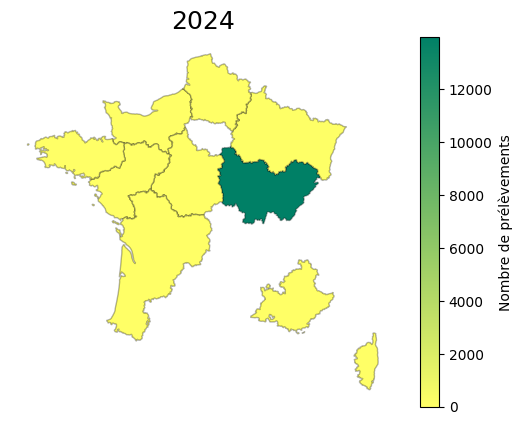

In [181]:
for k in range(len(y)):
    # remove frame from each side of plot
    plt.rcParams["axes.spines.left"] = False
    plt.rcParams["axes.spines.right"] = False
    plt.rcParams["axes.spines.top"] = False
    plt.rcParams["axes.spines.bottom"] = False

    res_region_carto[res_region_carto["Annee"] == y[k]].plot(
        column="Count",
        legend=True,
        cmap="summer_r",
        edgecolor=(0, 0, 0, 0.3),
        legend_kwds={"label": "Nombre de prélèvements"},
    )
    plt.xticks([])
    plt.yticks([])

    plt.title(str(y[k]), fontsize=18)

# Etude par région pour chaque paramètre


In [ ]:
query_region_param = """SELECT ANY_VALUE(cdparametre) AS cdparametre, ANY_VALUE(libminparametre) AS libminparametre, COUNT(referenceprel) AS Count, year(dateprel) AS Annee, ANY_VALUE(geo_clean.code_region) AS code_region, ANY_VALUE(geo_clean.nom_region) AS nom_region
FROM res
JOIN geo_clean
ON res.inseecommuneprinc=geo_clean.code_commune_INSEE
GROUP BY cdparametre,Annee,code_region
ORDER BY cdparametre,code_region,Annee"""

res_region_param = con.sql(query_region_param)
res_region_param = res_region_param.df()

In [ ]:
res_region_param

,cdparametre,libminparametre,Count,Annee,code_region,nom_region
0,1122,Bromoforme,77,2020,1,Guadeloupe
1,1122,Bromoforme,106,2021,1,Guadeloupe
2,1122,Bromoforme,117,2022,1,Guadeloupe
3,1122,Bromoforme,126,2023,1,Guadeloupe
4,1122,Bromoforme,132,2024,1,Guadeloupe
...,...,...,...,...,...,...
940,2036,Trihalométhanes (4 substances),332,2023,94,Corse
941,2036,Trihalométhanes (4 substances),253,2024,94,Corse
942,6279,Chlore libre actif,35,2021,44,Grand Est
943,6280,Chlore disponible,2,2022,75,Nouvelle-Aquitaine


# Fréquence de quantification de chaque paramètre


In [ ]:
query_tot = """SELECT ANY_VALUE(cdparametre) AS cdparametre, ANY_VALUE(libminparametre) AS libminparametre, COUNT(referenceprel) AS Count_total, year(dateprel) AS Annee
FROM res
GROUP BY cdparametre,Annee
ORDER BY cdparametre,Annee"""

res_tot = con.sql(query_tot)
res_tot = res_tot.df()

In [ ]:
res_tot.head(20)

,cdparametre,libminparametre,Count_total,Annee
0,1122,Bromoforme,12039,2020
1,1122,Bromoforme,11746,2021
2,1122,Bromoforme,11553,2022
3,1122,Bromoforme,11759,2023
4,1122,Bromoforme,11506,2024
5,1135,Chloroforme,12039,2020
6,1135,Chloroforme,11745,2021
7,1135,Chloroforme,11552,2022
8,1135,Chloroforme,11760,2023
9,1135,Chloroforme,11506,2024


In [ ]:
query_quantif = """SELECT ANY_VALUE(cdparametre) AS cdparametre, ANY_VALUE(libminparametre) AS libminparametre, COUNT(CASE WHEN valtraduite!=0 THEN 1 END) AS Count_quantif, year(dateprel) AS Annee
FROM res
GROUP BY cdparametre,Annee
ORDER BY cdparametre,Annee"""

res_quantif = con.sql(query_quantif)
res_quantif = res_quantif.df()

In [ ]:
res_quantif.head(5)

,cdparametre,libminparametre,Count_quantif,Annee
0,1122,Bromoforme,7690,2020
1,1122,Bromoforme,7991,2021
2,1122,Bromoforme,8198,2022
3,1122,Bromoforme,8441,2023
4,1122,Bromoforme,8515,2024


In [ ]:
res_quantification = res_tot.assign(
    Taux_quantification=np.divide(res_quantif.Count_quantif, res_tot.Count_total)
)

In [ ]:
res_quantification.head(5)

,cdparametre,libminparametre,Count_total,Annee,Taux_quantification
0,1122,Bromoforme,12039,2020,0.638757
1,1122,Bromoforme,11746,2021,0.680317
2,1122,Bromoforme,11553,2022,0.709599
3,1122,Bromoforme,11759,2023,0.717833
4,1122,Bromoforme,11506,2024,0.740049


Fréquence de quantification


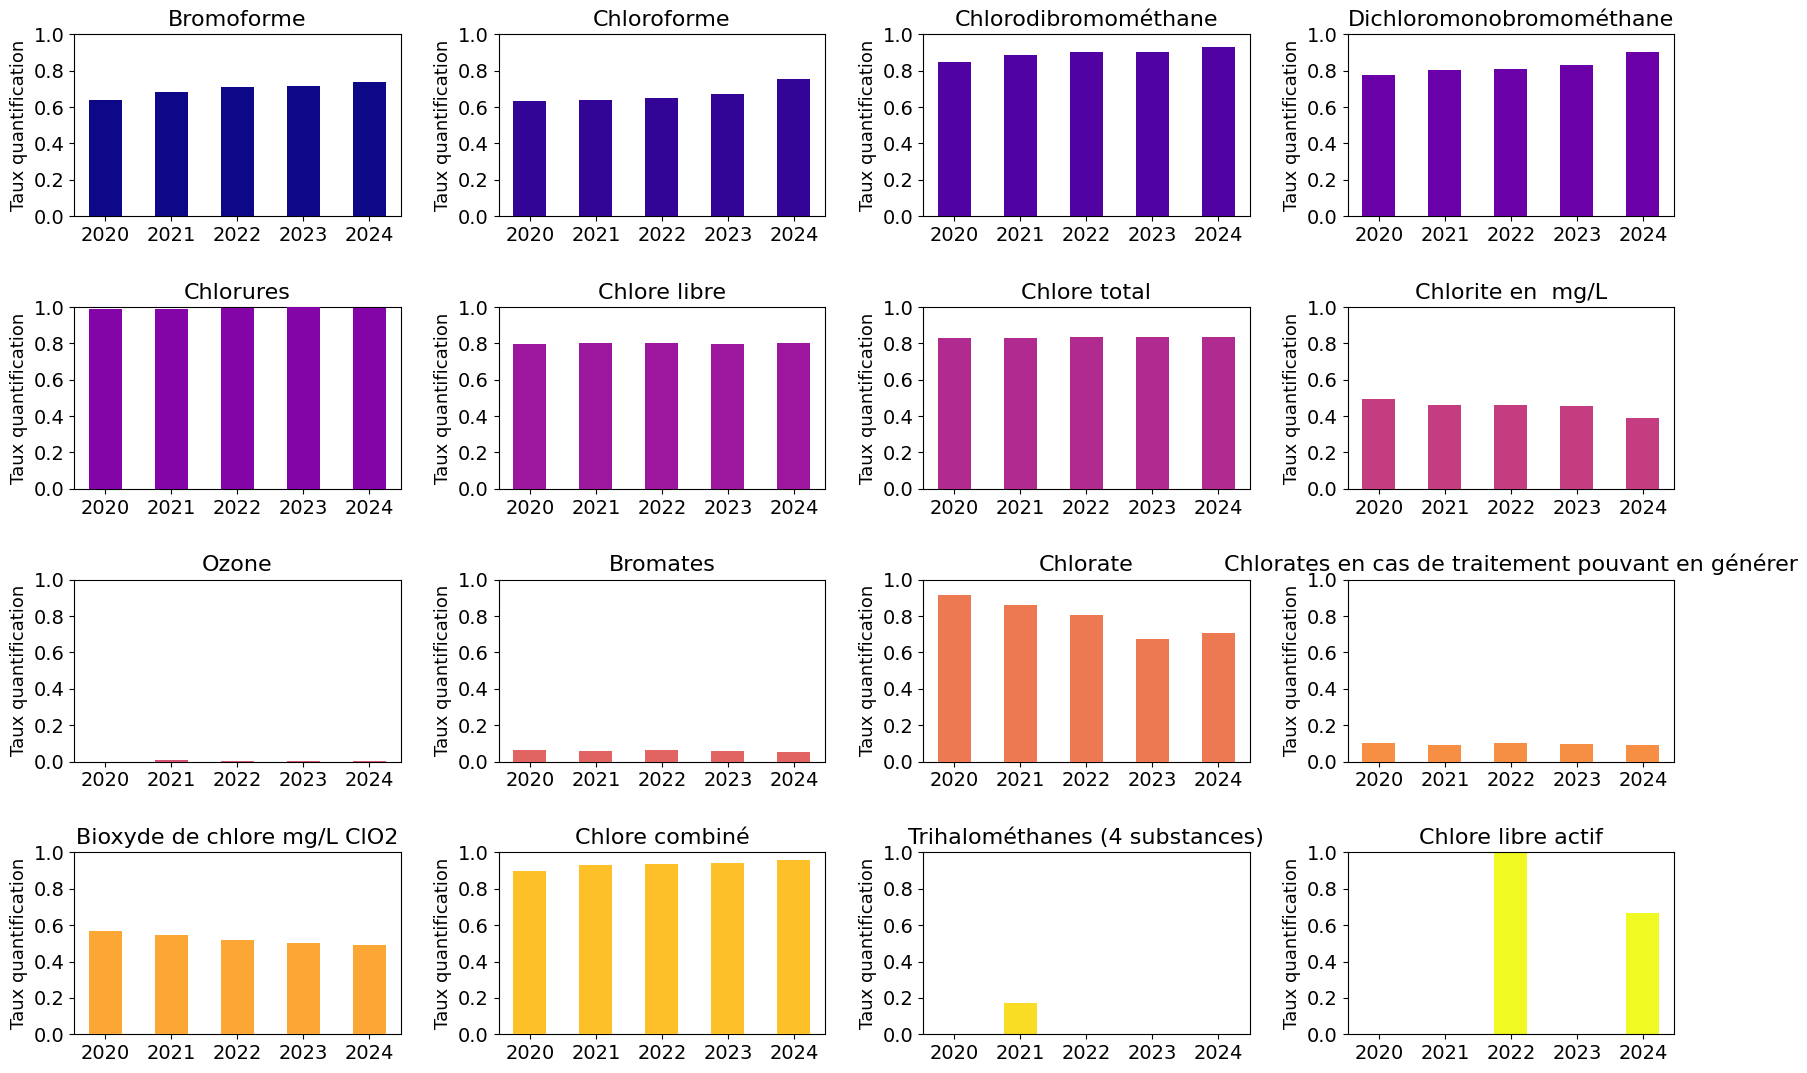

In [ ]:
print("Fréquence de quantification")
plt.rcParams["axes.spines.left"] = True
plt.rcParams["axes.spines.right"] = True
plt.rcParams["axes.spines.top"] = True
plt.rcParams["axes.spines.bottom"] = True

barWidth = 0.5

y = [2020, 2021, 2022, 2023, 2024]
y_data = []
aux = []
y_libminparametre = res_quantification["libminparametre"].unique()
y_cdparametre = res_quantification["cdparametre"].unique()
nb_param = len(y_cdparametre)

# On liste par annee le count de chaque parametre

for k in y_cdparametre:
    for m in y:
        arraux = res_quantification[
            (res_quantification["Annee"] == m)
            & (res_quantification["cdparametre"] == k)
        ]["Taux_quantification"]
        if len(arraux) > 0:
            aux.append(arraux.iloc[0])
        else:
            aux.append(0)
    y_data.append(aux)
    aux = []

br = [np.arange(len(y_data[0]))]

# for k in range(nb_param):
#    br.append([x + barWidth for x in br[k]])

f = plt.figure(figsize=(16, 10))
color = matplotlib.colormaps["plasma"]

for k in range(nb_param):
    plt.subplot(4, 4, k + 1)
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.bar(
        y,
        y_data[k],
        color=color(k / (nb_param - 1)),
        width=barWidth,
        zorder=nb_param - k,
        alpha=1.0,
    )
    plt.title(y_libminparametre[k], fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel("Taux quantification", fontsize=13)

plt.subplots_adjust(wspace=0.3, hspace=0.5, left=0, right=1, bottom=0, top=1)
plt.show()

# Fréquence de dépassement


In [ ]:
query_dep = """SELECT ANY_VALUE(cdparametre) AS cdparametre, ANY_VALUE(libminparametre) AS libminparametre, COUNT(CASE WHEN valtraduite > CAST(regexp_extract(REPLACE("limitequal", ',', '.'), '-?\d+(\.\d+)?') AS FLOAT) THEN 1 END) AS Count_dep, year(dateprel) AS Annee
FROM res
GROUP BY cdparametre,Annee
ORDER BY cdparametre,Annee"""

res_dep = con.sql(query_dep)
res_dep = res_dep.df()

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Admin\AppData\Local\Temp\ipykernel_3420\2146791387.py:1: SyntaxWarning: invalid escape sequence '\d'
  query_dep = """SELECT ANY_VALUE(cdparametre) AS cdparametre, ANY_VALUE(libminparametre) AS libminparametre, COUNT(CASE WHEN valtraduite > CAST(regexp_extract(REPLACE("limitequal", ',', '.'), '-?\d+(\.\d+)?') AS FLOAT) THEN 1 END) AS Count_dep, year(dateprel) AS Annee


In [ ]:
res_dep.head(15)

,cdparametre,libminparametre,Count_dep,Annee
0,1122,Bromoforme,1,2020
1,1122,Bromoforme,0,2021
2,1122,Bromoforme,5,2022
3,1122,Bromoforme,0,2023
4,1122,Bromoforme,0,2024
5,1135,Chloroforme,9,2020
6,1135,Chloroforme,10,2021
7,1135,Chloroforme,20,2022
8,1135,Chloroforme,42,2023
9,1135,Chloroforme,29,2024


In [ ]:
res_tauxdep = res_tot.assign(
    Taux_depassement=np.divide(res_dep.Count_dep, res_tot.Count_total)
)

Fréquence de dépassement


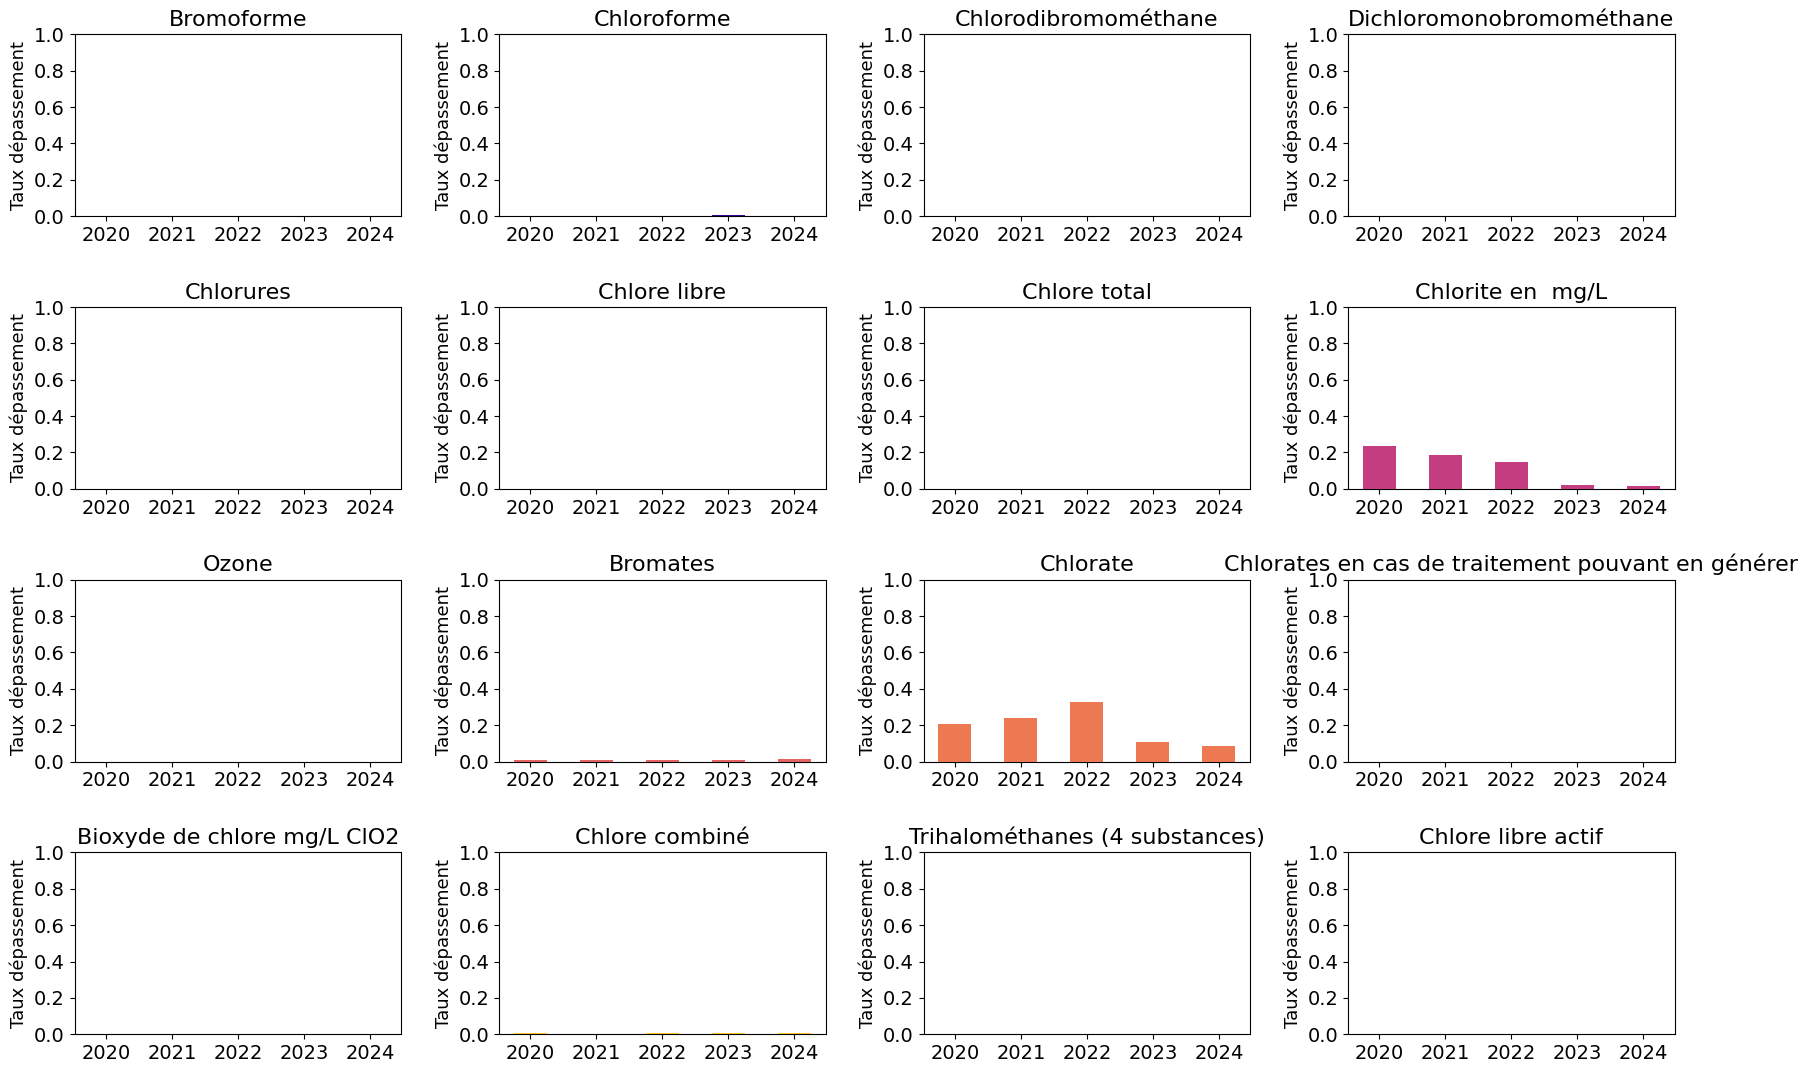

In [ ]:
print("Fréquence de dépassement")
plt.rcParams["axes.spines.left"] = True
plt.rcParams["axes.spines.right"] = True
plt.rcParams["axes.spines.top"] = True
plt.rcParams["axes.spines.bottom"] = True

barWidth = 0.5

y = [2020, 2021, 2022, 2023, 2024]
y_data = []
aux = []
y_libminparametre = res_tauxdep["libminparametre"].unique()
y_cdparametre = res_tauxdep["cdparametre"].unique()
nb_param = len(y_cdparametre)

# On liste par annee le count de chaque parametre

for k in y_cdparametre:
    for m in y:
        arraux = res_tauxdep[
            (res_tauxdep["Annee"] == m) & (res_tauxdep["cdparametre"] == k)
        ]["Taux_depassement"]
        if len(arraux) > 0:
            aux.append(arraux.iloc[0])
        else:
            aux.append(0)
    y_data.append(aux)
    aux = []

br = [np.arange(len(y_data[0]))]

# for k in range(nb_param):
#    br.append([x + barWidth for x in br[k]])

f = plt.figure(figsize=(16, 10))
color = matplotlib.colormaps["plasma"]

for k in range(nb_param):
    plt.subplot(4, 4, k + 1)
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.bar(
        y,
        y_data[k],
        color=color(k / (nb_param - 1)),
        width=barWidth,
        zorder=nb_param - k,
        alpha=1.0,
    )
    plt.title(y_libminparametre[k], fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel("Taux dépassement", fontsize=13)

plt.subplots_adjust(wspace=0.3, hspace=0.5, left=0, right=1, bottom=0, top=1)
plt.show()

# Fréquence de dépassement par année et par région


In [ ]:
query_region_dep = """SELECT COUNT(CASE WHEN valtraduite > CAST(regexp_extract(REPLACE("limitequal", ',', '.'), '-?\d+(\.\d+)?') AS FLOAT) THEN 1 END) AS Count_dep, COUNT(referenceprel) AS Count_tot, year(dateprel) AS Annee, ANY_VALUE(geo_clean.code_region) AS code_region, ANY_VALUE(geo_clean.nom_region) AS nom_region
FROM res
JOIN geo_clean
ON res.inseecommuneprinc=geo_clean.code_commune_INSEE
GROUP BY Annee,code_region
ORDER BY code_region,Annee"""

res_region_dep = con.sql(query_region_dep)
res_region_dep = res_region_dep.df()

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Admin\AppData\Local\Temp\ipykernel_3420\1559782231.py:1: SyntaxWarning: invalid escape sequence '\d'
  query_region_dep = """SELECT COUNT(CASE WHEN valtraduite > CAST(regexp_extract(REPLACE("limitequal", ',', '.'), '-?\d+(\.\d+)?') AS FLOAT) THEN 1 END) AS Count_dep, COUNT(referenceprel) AS Count_tot, year(dateprel) AS Annee, ANY_VALUE(geo_clean.code_region) AS code_region, ANY_VALUE(geo_clean.nom_region) AS nom_region


In [ ]:
res_region_dep

,Count_dep,Count_tot,Annee,code_region,nom_region
0,1,1928,2020,1,Guadeloupe
1,2,2387,2021,1,Guadeloupe
2,2,3325,2022,1,Guadeloupe
3,3,3108,2023,1,Guadeloupe
4,2,3054,2024,1,Guadeloupe
...,...,...,...,...,...
85,3,8360,2020,94,Corse
86,7,8899,2021,94,Corse
87,4,9263,2022,94,Corse
88,15,9073,2023,94,Corse


In [ ]:
res_region_dep = res_region_dep.assign(
    Taux_depassement=np.divide(res_region_dep.Count_dep, res_region_dep.Count_tot)
)

In [ ]:
res_region_dep = region.join(res_region_dep.set_index("code_region"), on="code")
res_region_dep = res_region_dep.set_geometry("geometry")

Cartographie du taux de dépassement pour les métaux lourds à l'échelle régionale


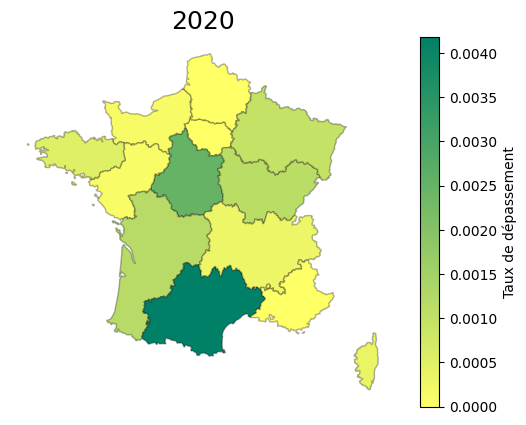

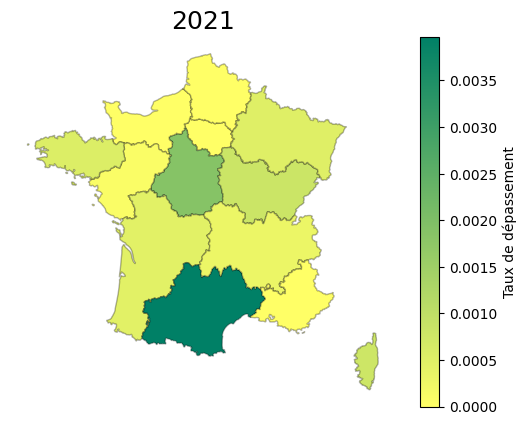

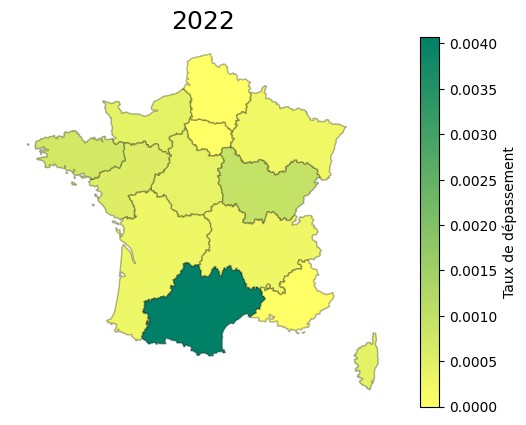

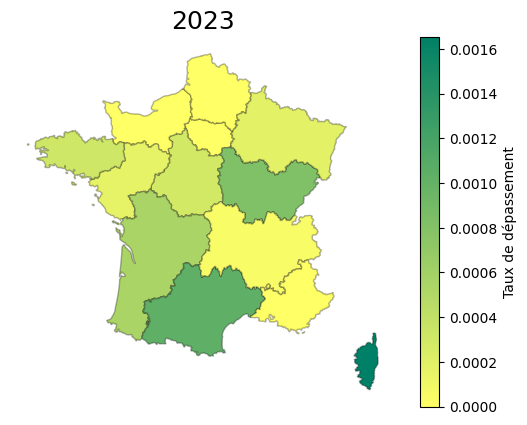

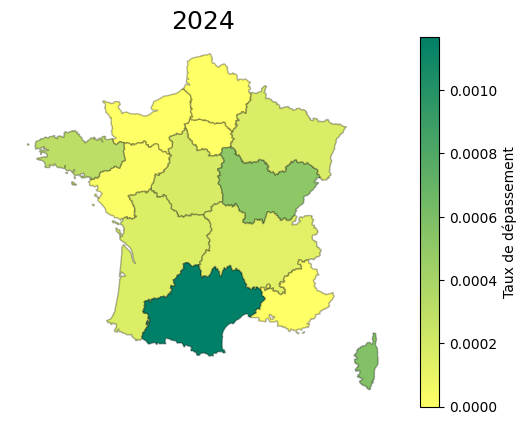

In [ ]:
print(
    "Cartographie du taux de dépassement pour les métaux lourds à l'échelle régionale"
)
for k in range(len(y)):
    # remove frame from each side of plot
    plt.rcParams["axes.spines.left"] = False
    plt.rcParams["axes.spines.right"] = False
    plt.rcParams["axes.spines.top"] = False
    plt.rcParams["axes.spines.bottom"] = False

    res_region_dep[res_region_dep["Annee"] == y[k]].plot(
        column="Taux_depassement",
        legend=True,
        cmap="summer_r",
        edgecolor=(0, 0, 0, 0.3),
        legend_kwds={"label": "Taux de dépassement"},
    )
    plt.xticks([])
    plt.yticks([])

    plt.title(str(y[k]), fontsize=18)

# Extraction de la liste des régions où ont été faites les analyses


In [ ]:
query_region_excel = """SELECT cdparametre, ANY_VALUE(libminparametre) AS libminparametre, year(dateprel) AS Annee, ANY_VALUE(geo_clean.nom_region) AS nom_region, ANY_VALUE(geo_clean.code_region) AS code_region
FROM res
JOIN geo_clean
ON res.inseecommuneprinc=geo_clean.code_commune_INSEE
GROUP BY cdparametre,Annee, nom_region
ORDER BY cdparametre,Annee"""

res_region_excel = con.sql(query_region_excel)
res_region_excel = res_region_excel.df()

In [ ]:
res_region_excel

,cdparametre,libminparametre,Annee,nom_region,code_region
0,1122,Bromoforme,2020,Île-de-France,11
1,1122,Bromoforme,2020,Guyane,3
2,1122,Bromoforme,2020,Martinique,2
3,1122,Bromoforme,2020,Centre-Val de Loire,24
4,1122,Bromoforme,2020,Guadeloupe,1
...,...,...,...,...,...
940,2036,Trihalométhanes (4 substances),2024,Normandie,28
941,2036,Trihalométhanes (4 substances),2024,Guyane,3
942,6279,Chlore libre actif,2021,Grand Est,44
943,6280,Chlore disponible,2022,Nouvelle-Aquitaine,75


In [ ]:
# j'ai pas réussi à le faire en une seule query sql

In [ ]:
query_region_excel2 = """SELECT ANY_VALUE(cdparametre) AS cdparametre, ANY_VALUE(libminparametre) AS libminparametre, ANY_VALUE(Annee) AS Annee, GROUP_CONCAT(nom_region) AS Liste_noms_regions, GROUP_CONCAT(code_region) AS Liste_codes_regions, COUNT(code_region) AS Nombre_de_regions
FROM res_region_excel
GROUP BY cdparametre,Annee
ORDER BY cdparametre,Annee"""

res_region_excel2 = con.sql(query_region_excel2)
res_region_excel2 = res_region_excel2.df()

In [ ]:
res_region_excel2

,cdparametre,libminparametre,Annee,Liste_noms_regions,Liste_codes_regions,Nombre_de_regions
0,1122,Bromoforme,2020,"Île-de-France,Guyane,Martinique,Centre-Val de ...","11,3,2,24,1,44,28,84,32,52,94,75,53,93,76,27,4,6",18
1,1122,Bromoforme,2021,"Corse,Auvergne-Rhône-Alpes,Hauts-de-France,Pay...","94,84,32,52,93,76,53,2,27,4,6,11,3,44,28,75,24,1",18
2,1122,Bromoforme,2022,"Occitanie,Hauts-de-France,Pays de la Loire,Auv...","76,32,52,84,94,75,3,24,1,2,44,28,53,27,4,6,11,93",18
3,1122,Bromoforme,2023,"Occitanie,Hauts-de-France,Auvergne-Rhône-Alpes...","76,32,84,52,94,27,4,6,11,53,2,24,1,93,75,3,44,28",18
4,1122,Bromoforme,2024,"Guyane,Île-de-France,Bretagne,Centre-Val de Lo...","3,11,53,24,1,2,93,76,52,84,32,94,27,4,6,44,28,75",18
...,...,...,...,...,...,...
67,2036,Trihalométhanes (4 substances),2023,"Hauts-de-France,Auvergne-Rhône-Alpes,Pays de l...","32,84,52,94,44,28,76,24,1,75,3,11,93,27,4,6,53,2",18
68,2036,Trihalométhanes (4 substances),2024,"Nouvelle-Aquitaine,Centre-Val de Loire,Guadelo...","75,24,1,52,84,32,94,27,4,6,2,53,76,93,11,44,28,3",18
69,6279,Chlore libre actif,2021,Grand Est,44,1
70,6280,Chlore disponible,2022,Nouvelle-Aquitaine,75,1


# Création du fichier excel


In [ ]:
base = (
    res[["cdparametre", "libminparametre", "limitequal"]]
    .drop_duplicates()
    .sort_values(by=["cdparametre"])
    .drop_duplicates(subset="cdparametre")
)

In [ ]:
excel_df = []
for k in y:
    query_excel1 = (
        """SELECT base.*, res_tauxdep.Annee, res_tauxdep.Taux_depassement, res_quantification.Taux_quantification, countglobal.Count AS Nombre_de_recherches, res_quantif.Count_quantif AS Nombre_de_quantifications, res_dep.Count_dep AS Nombre_de_depassements, res_region_excel2.Liste_noms_regions, res_region_excel2.Liste_codes_regions, res_region_excel2.Nombre_de_regions
    FROM base
        JOIN res_tauxdep
        ON base.cdparametre = res_tauxdep.cdparametre
        JOIN res_quantification
        ON base.cdparametre = res_quantification.cdparametre
        JOIN countglobal
        ON base.cdparametre = countglobal.cdparametre
        JOIN res_region_excel2
        ON base.cdparametre = res_region_excel2.cdparametre
        JOIN res_quantif
        ON base.cdparametre = res_quantif.cdparametre
        JOIN res_dep
        ON base.cdparametre = res_dep.cdparametre
    WHERE 
        (res_tauxdep.Annee = """
        + str(k)
        + """)
        AND
        (res_quantification.Annee = """
        + str(k)
        + """)
        AND
        (countglobal.Annee = """
        + str(k)
        + """)
        AND
        (res_region_excel2.Annee = """
        + str(k)
        + """)
        AND
        (res_quantif.Annee = """
        + str(k)
        + """)
        AND
        (res_dep.Annee = """
        + str(k)
        + """)
    ORDER BY base.cdparametre,res_tauxdep.Annee
    """
    )
    res_excel1 = con.sql(query_excel1)
    res_excel1 = res_excel1.df()
    excel_df.append(res_excel1)


In [ ]:
from pandas import ExcelWriter
import xlsxwriter


with pd.ExcelWriter("sousproduitsdesinfection.xlsx", engine="xlsxwriter") as writer:
    for k in range(len(y)):
        excel_df[k].to_excel(writer, sheet_name=str(y[k]))
